# The Mean Squares

### Team Contributions:

|Features  |  Member |
|-----|-----|
| Bias |  Wasae Qureshi |
| Credibility & Reliability |  Pranav Lodha |
| News Converage |  Subarna Chowdhury Soma  |
| Micro Pattern |  Jeyasri Subramanian  |

## Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset

In [3]:
# Load Dataset from drive
fake_news_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/fake.csv', low_memory =False)
fake_news_data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [0]:
#X_train, X_test, y_train, y_test = train_test_split(fake_news_data, y, test_size=0.2)

## Preprocessing

In [0]:
fake_news_data = fake_news_data.dropna()

In [0]:
import re

def cleaning(raw_news):
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [7]:
import time

t1 = time.time()
fake_news_data['clean_title'] = fake_news_data["title"].apply(cleaning) 
t2 = time.time()
print("\nTime to clean, tokenize and stem title in fake_news_data: \n", len(fake_news_data), "news:", (t2-t1)/60, "min")

t1 = time.time()
fake_news_data['clean_thread_title'] = fake_news_data["thread_title"].apply(cleaning) 
t2 = time.time()
print("\nTime to clean, tokenize and stem thread_title in fake_news_data: \n", len(fake_news_data), "news:", (t2-t1)/60, "min")

# Testing
# t1 = time.time()
# fake_news_data['clean_text'] = fake_news_data["text"].apply(cleaning) 
# t2 = time.time()
# print("\nTime to clean, tokenize and stem text in fake_news_data: \n", len(fake_news_data), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem title in fake_news_data: 
 4702 news: 0.06481265624364217 min

Time to clean, tokenize and stem thread_title in fake_news_data: 
 4702 news: 0.03734453121821086 min


In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [11]:
print("Before: \n", fake_news_data['clean_title'][0] )
t1 = time.time()
fake_news_data['clean_title'] = fake_news_data['clean_title'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the clean_title in fake_news_data: \n", len(fake_news_data), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",fake_news_data['clean_title'][0] )
fake_news_data.head(2)

print("Before: \n", fake_news_data['clean_thread_title'][0] )
t1 = time.time()
fake_news_data['clean_thread_title'] = fake_news_data['clean_thread_title'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the clean_thread_title in fake_news_data: \n", len(fake_news_data), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",fake_news_data['clean_thread_title'][0] )
fake_news_data.head(2)

Before: 
 muslim bust stole million gov benefit

Time to spell check the clean_title in fake_news_data: 
 4702 news: 2.8603270093599957 min

After: 
 muslim bust stole million gov benefit
Before: 
 muslim bust stole million gov benefit

Time to spell check the clean_thread_title in fake_news_data: 
 4702 news: 2.8640889286994935 min

After: 
 muslim bust stole million gov benefit


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_title,clean_thread_title
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,muslim bust stole million gov benefit,muslim bust stole million gov benefit
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney general lotta lynch plead fifth,attorney general lotta lynch plead fifth


In [12]:
fake_news_data['type'].value_counts()

bs            4064
bias           271
conspiracy     163
hate            99
junksci         97
state            6
fake             2
Name: type, dtype: int64

## Visualizations

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

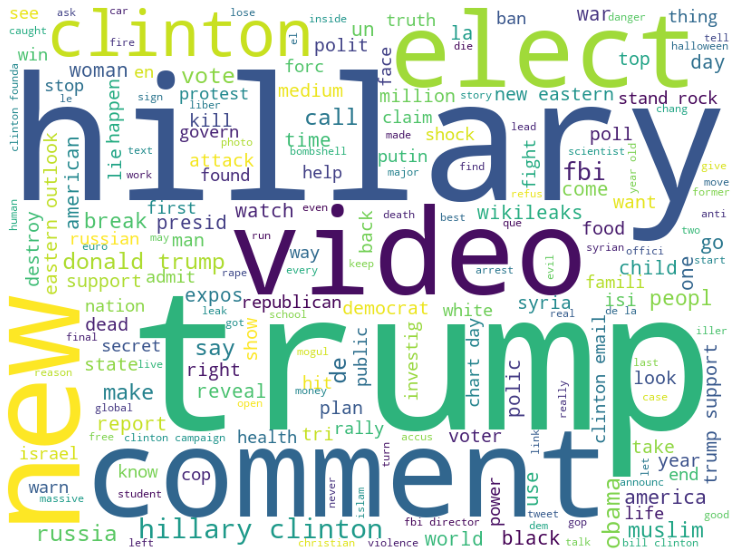

In [14]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(fake_news_data['clean_title']))

## Feature 1: Sentiment Analysis

In [15]:
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(fake_news_data['clean_title'][0])

muslim bust stole million gov benefit--- 
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.4588}


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [0]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

In [18]:
sentiment = []
vader_pol = []
cmp_score = []
for row in fake_news_data['clean_title']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
fake_news_data['sentiment_vector'] = sentiment
fake_news_data['vader_polarity'] = vader_pol
fake_news_data['sentiment_score'] = cmp_score

[0, 0.0, 0.625, 0.375, 0.4588]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.382, 0.618, 0.0, -0.7783]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.25, 0.75, 0.0, -0.25]
[0, 0.116, 0.638, 0.246, 0.6486]
[0, 0.268, 0.515, 0.216, -0.128]
[0, 0.081, 0.604, 0.315, 0.5423]
[0, 0.19, 0.693, 0.117, -0.4019]
[0, 0.0, 0.737, 0.263, 0.3612]
[0, 0.224, 0.776, 0.0, -0.3818]
[0, 0.128, 0.542, 0.33, 0.6249]
[0, 0.203, 0.797, 0.0, -0.4215]
[0, 0.152, 0.606, 0.242, 0.296]
[0, 0.164, 0.643, 0.193, 0.1027]
[0, 0.0, 0.803, 0.197, 0.4019]
[0, 0.103, 0.538, 0.359, 0.5719]
[0, 0.0, 1.0, 0.0, 0.0]
[1, 0.248, 0.284, 0.468, 0.6249]
[0, 0.145, 0.636, 0.22, 0.3182]
[0, 0.23, 0.618, 0.152, -0.34]
[0, 0.198, 0.581, 0.221, 0.1027]
[0, 0.077, 0.769, 0.154, 0.34]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.229, 0.422, 0.349, 0.25]
[0, 0.348, 0.652, 0.0, -0.7506]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.439, 0.561, 0.0, -0.6908]
[0, 0.0, 0.865, 0.135, 0.3612]
[0, 0.44, 0.444, 0.117, -0.8402]
[0, 0.0, 0

In [19]:
'''
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalysis():

    def __init__(self):        

        #columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]
        columnNames = ["uuid", "ord_in_thread", "author", "published", "title", "text", "langauge", "crawled", "site_url", "country", "domain_rank", "thread_title", "spam_score", "main_img_url", "replies_count", "participants_count", "likes", "comments", "shares", "type", "clean_title", "clean_thread_title","sentiment_vector","vader_polarity", "sentiment_score"]
        dataTrain = pd.read_csv('input_data/train_sentiment.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_sentiment.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['vader_polarity'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['vader_polarity'], predicted_LogR)
        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
sa = SentimentAnalysis()
sa.predict("Says the Annies List political group supports third-trimester abortions on demand.")
'''

'\nimport pandas as pd\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.linear_model import  LogisticRegression\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom nltk.stem.porter import *\nfrom sklearn import metrics\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\nclass SentimentAnalysis():\n\n    def __init__(self):        \n\n        #columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]\n        columnNames = ["uuid", "ord_in_thread", "author", "published", "title", "text", "langauge", "crawled", "site_url", "country", "domain_rank", "thread_title", "spam_score", "main_img_url", "replies_count", "participants_count", "likes", "comments", "shares", "type", "clean_title", "clean_thread_title","sentiment_ve

In [0]:
#SentimentAnalysis = SentimentAnalysis()

In [21]:
'''
def DATAMINERS_getSentimentAnalysisScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = SentimentAnalysis.predict(text)
    return (float(probValue))

print(DATAMINERS_getSentimentAnalysisScore("Says the Annies List political group supports third-trimester abortions on demand."))
'''

'\ndef DATAMINERS_getSentimentAnalysisScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake\n    #print(clickBait.predict("Should You bring the money now"))\n    binaryValue, probValue = SentimentAnalysis.predict(text)\n    return (float(probValue))\n\nprint(DATAMINERS_getSentimentAnalysisScore("Says the Annies List political group supports third-trimester abortions on demand."))\n'

## Feature 2: LDA Topic Modelling

In [22]:
fake_news_data['index'] = fake_news_data.index
data = fake_news_data
train_lda = data[['clean_title', 'index']]
train_lda.head(4)

,clean_title,index
0,muslim bust stole million gov benefit,0
1,attorney general lotta lynch plead fifth,1
2,break weiner cooper fbi hillary email investig,2
3,pin drop speech father daughter kidnap kill is...,3


In [23]:
processed_docs = train_lda['clean_title'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0         [muslim, bust, stole, million, gov, benefit]
1      [attorney, general, lotta, lynch, plead, fifth]
2    [break, weiner, cooper, fbi, hillary, email, i...
3    [pin, drop, speech, father, daughter, kidnap, ...
Name: clean_title, dtype: object

In [0]:

def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = fake_news_data['clean_title'].map(get_word_tokens)

In [0]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

In [0]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [0]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

In [0]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

In [0]:

def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [0]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [0]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [32]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(fake_news_data, 'clean_title')

######## DICTIONARY Words and occurences ########
0 benefit
1 bust
2 gov
3 million
4 muslim
5 stole
6 attorney
7 fifth
8 general
9 lotta
10 lynch

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1)]

 ######## PREVIEW BOW ########
Word 0 ("bust") appears 1 time.
Word 1 ("million") appears 1 time.
Word 2 ("muslim") appears 1 time.


In [33]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['elect', 'trump', 'clinton', 'hillary', 'messin', 'thier', 'campaign', 'video', 'admit', 'poll']
1::['comment', 'world', 'show', 'call', 'para', 'peopl', 'trump', 'health', 'warn', 'take']
2::['trump', 'water', 'woman', 'peopl', 'year', 'vote', 'russia', 'truth', 'control', 'anti']
3::['clinton', 'black', 'hillary', 'found', 'come', 'danger', 'peopl', 'refus', 'scientist', 'dead']
4::['make', 'govern', 'vote', 'syria', 'machin', 'scientist', 'obama', 'life', 'elect', 'presid']
5::['clinton', 'hillary', 'polic', 'trump', 'time', 'protest', 'bill', 'email', 'investig', 'explain']
6::['hillary', 'clinton', 'trump', 'obama', 'elect', 'russia', 'million', 'food', 'putin', 'muslim']
7::['mansion', 'dinucci', 'right', 'american', 'plan', 'clinton', 'nuclear', 'obama', 'never', 'eastern']
8::['trump', 'hillary', 'clinton', 'vote', 'support', 'donald', 'wikileaks', 'email', 'voter', 'expos']
9::['clinton', 'trump', 'stand', 'rock', 'comment', 'link', 'hillary', 'iller', 'claim', 'break']


In [34]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(0, 0.698046161401141), (1, 0.548639685496598), (2, 0.4601369927003548)]


In [35]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['clinton', 'face', 'american', 'polic', 'control', 'campaign', 'trump', 'hillary', 'nato', 'refus']
1::['found', 'putin', 'danger', 'deal', 'year', 'trump', 'american', 'rally', 'scientist', 'speak']
2::['america', 'woman', 'truth', 'real', 'wikileaks', 'democrat', 'last', 'secret', 'million', 'euro']
3::['year', 'email', 'clinton', 'cancer', 'govern', 'hillary', 'link', 'iller', 'fall', 'make']
4::['world', 'dinucci', 'mansion', 'stand', 'rock', 'clinton', 'medium', 'water', 'health', 'hillary']
5::['trump', 'right', 'state', 'human', 'presid', 'para', 'messin', 'thier', 'know', 'never']
6::['trump', 'hillary', 'russia', 'power', 'world', 'donald', 'lose', 'vote', 'good', 'clinton']
7::['syria', 'elect', 'peopl', 'tell', 'fraud', 'hand', 'paul', 'polit', 'life', 'clinton']
8::['black', 'show', 'reason', 'strike', 'bodi', 'woman', 'busi', 'latest', 'megan', 'start']
9::['mogul', 'white', 'trump', 'famili', 'nuclear', 'thier', 'messin', 'anti', 'hous', 'happen']


In [0]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [37]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
fake_news_data = update_lda_results_to_dataset(
    fake_news_data, headlinetopiccolnames,'clean_title', dictionary_headline, lda_model_headline, lda_headline_topic_words)
fake_news_data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_title,clean_thread_title,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,muslim bust stole million gov benefit,muslim bust stole million gov benefit,"[0.0, 0.625, 0.375, 0.4588]",0,0.4588,0,6,0.500422,hillary clinton trump obama elect russia milli...
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney general lotta lynch plead fifth,attorney general lotta lynch plead fifth,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,4,0.699962,make govern vote syria machin scientist obama ...
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,break weiner cooper fbi hillary email investig,break weiner cooper fbi hillary email investig,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,2,6,0.849979,hillary clinton trump obama elect russia milli...
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,pin drop speech father daughter kidnap kill is...,pin drop speech father daughter kidnap kill is...,"[0.382, 0.618, 0.0, -0.7783]",0,-0.7783,3,8,0.395526,trump hillary clinton vote support donald wiki...
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,fantasy trump point plan reform healthcare beg...,fantasy trump point plan reform healthcare beg...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,4,8,0.849955,trump hillary clinton vote support donald wiki...


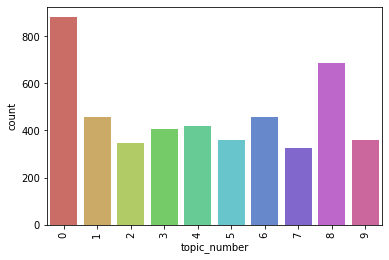

In [38]:
import seaborn as sb
def create_distribution(dataFile):
    g = sb.countplot(x='topic_number', data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

create_distribution(fake_news_data) # TRAIN Document Vector

In [39]:
'''
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class LDATopicModelling():

    def __init__(self):        

        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
        dataTrain = pd.read_csv('input_data/train_lda.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('input_data/test_lda.csv', sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['topic_number'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['topic_number'], predicted_LogR)
        print("LDA Topic Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    
# lda = LDATopicModelling()
# lda.predict("Says the Annies List political group supports third-trimester abortions on demand.")
'''

'\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.linear_model import  LogisticRegression\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom nltk.stem.porter import *\nfrom sklearn import metrics\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\nclass LDATopicModelling():\n\n    def __init__(self):        \n\n        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]\n        dataTrain = pd.read_csv(\'input_data/train_lda.csv\', sep=\',\', header=None, names = columnNames)\n        dataTest = pd.read_csv(\'input_data/test_lda.csv\', sep=\',\', header=None, names = columnNames)\n\n        #dropping columns\n        columnsToRemove = [\'jsonid\', \'lab

In [0]:
#ldaTopicModelling = LDATopicModelling()

In [41]:
'''
def DATAMINERS_getLDATopicModellingScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = ldaTopicModelling.predict(text)
    return (float(probValue))

print(DATAMINERS_getLDATopicModellingScore("Says the Annies List political group supports third-trimester abortions on demand."))
'''

'\ndef DATAMINERS_getLDATopicModellingScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake\n    #print(clickBait.predict("Should You bring the money now"))\n    binaryValue, probValue = ldaTopicModelling.predict(text)\n    return (float(probValue))\n\nprint(DATAMINERS_getLDATopicModellingScore("Says the Annies List political group supports third-trimester abortions on demand."))\n'

In [0]:
#Storing to csv
fake_news_data.to_csv("/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 3/Datasets/fake_news_data_lda.csv", sep=',')

## Feature 3: Sensational Feature Analysis

In [0]:
columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 3/Datasets/fake_news_data_lda.csv', sep=',')
#dataTest = pd.read_csv('input_data/test_lda.csv', sep=',', header=None, names = columnNames)

#dropping columns
#columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index', 'topic_number', 'lda_score', 'topic_top_words']
#train_news = dataTrain.drop(columns=columnsToRemove)

#### Need to find the sensational_words_dict.csv and senticnet5.txt

In [44]:
corpus = []
for i in train_news['clean']:
    corpus.append(i)
# corpus

sensational_corpus=[]
sensational_words = pd.read_csv('input_data/sensationalism/sensational_words_dict.csv', sep="\t+", header=None, usecols=[0] )
print(len(sensational_words))
sensational_dictionary = ' '.join(sensational_words[0].astype(str))
sensational_corpus.append(sensational_dictionary)

NameError: ignored

In [0]:
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
sentic_net = pd.read_csv('input_data/sensationalism/senticnet5.txt', sep="\t+", header=None, usecols=[0,1,2], names = ["Token", "Polarity", "Intensity"])
sentic_net = sentic_net[~sentic_net['Token'].str.contains('|'.join('_'),na=False)]
sentic_net = sentic_net.reset_index(drop=True)
print("Senticnet Vocab Size: ",len(sentic_net))
print(sentic_net.head(10))

In [0]:
# sentic_net['Token'] provides list of words from the SenticNet DICTIONARY
senti_pos = sentic_net.loc[sentic_net.Polarity == "positive"]
senti_pos = senti_pos.loc[senti_pos.Intensity > 0.90]
dictionary = ' '.join(senti_pos.Token.astype(str))
sensational_corpus.append(dictionary)
print(len(senti_pos))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer(max_features=1000)

tfidf_corpus = tfidfVec.fit_transform(corpus)
tf_idf_senti = tfidfVec.fit_transform(sensational_corpus)
words = tfidfVec.get_feature_names()

In [0]:
tfidf_corpus.toarray()

In [0]:
tf_idf_senti.toarray()

In [0]:
tfidfVec.vocabulary_

In [0]:
train_tfidf = tfidfVec.fit_transform(fake_news_data['clean_title'])
print('Training dim:', train_tfidf.shape)
print(train_tfidf.A[:10])

In [0]:
from scipy import spatial
similarity_score = []
for i in range(len(train_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))

In [0]:
fake_news_data['sensational_score'] = similarity_score
fake_news_data.head(5)

In [0]:
corpus = []
for i in fake_news_data['clean_title']:
    corpus.append(i)
# corpus

tfidf_corpus = tfidfVec.fit_transform(corpus)

similarity_score = []
for i in range(len(test_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))
    
test_news['sensational_score'] = similarity_score
test_news.head(5)

## Feature 4: Political Affiliation Model

In [0]:
fake_news_data['label'] = 'false'

In [51]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import itertools

class PartyAffiliation():
    
    # API to check whether the subject(Headline) is present in the 
    # - democrats most used words if the party affiliation is democrat
    # - republicans most used words if the part affiliation is republican
    def partyAffiliationFromHeadline(self, r):
        v = r['subject_str']
        p = r['party_str']
        if (p =='democrat'):
            s2 = set(self.countDemV.get_feature_names())
        if (p =='republican'):
            s2 = set(self.countRepV.get_feature_names())
        if (p != 'democract' and p !='republican'):
            return 1 #'true'        
        if set(v).intersection(s2):
            return 1 #'true'
        else:
            return 0 #'false'

    #API to convert true, mostly-true and half-true to true
    # false, barely-true and pants-fire to false
    def convertMulticlassToBinaryclass(self, r):
        v = r['label']
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'
            
            
            
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')       
            
    
    def __init__(self):        

        columnNamesPar = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrainPar = fake_news_data
        
    
        # Remove unwanted columns in the dataset
        columnsToRemovePar = ['id', 'speaker', 'context','speaker_job_title', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        #dataTrainPar = dataTrainPar.drop(columns=columnsToRemovePar)
        
        # convert the labels to true and false only
        dataTrainPar['label'] = dataTrainPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        
        
        # display all the party affiliations and show the count of each party 
#         dataTrainPar.groupby('party_affiliation').count()[['state_info']].rename(
#         columns={'state_info': 'count'}).sort_values(
#         'count', ascending=False).reset_index().plot.bar(
#         x='party_affiliation', y='count', figsize=(16, 10), fontsize=18);
        
        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations
        rowsToRemove = ['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'ocean-state-tea-party-action', 'organization', 'state-official', 'talk-show-host', 'tea-party-member']
'''
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'Moderate']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'activist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'business-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'columnist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'constitution-party']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'democratic-farmer-labor']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'education-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'government-body']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'green']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'independent']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'journalist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'labor-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'liberal-party-canada']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'libertarian']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'nan']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'newsmaker']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'organization']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'state-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'talk-show-host']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'tea-party-member']


        

        dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
        
 '''       

        #predicting truth level
#        dataTrainPar.groupby('label').count()[['party_affiliation']].reset_index().plot.bar(x='label', y='party_affiliation')
        
        # get the most used democrat words
        self.countDemV = CountVectorizer(stop_words='english', min_df=40, max_df=80, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        dataTrainDem= dataTrainPar
        dataTrainDem = dataTrainPar.loc[dataTrainPar['party_str'] == 'democrat']
        dem_count = self.countDemV.fit_transform(dataTrainDem['statement'].values)
        
        #get the republican most used words
        
        self.countRepV = CountVectorizer(stop_words='english', min_df=20, max_df=40, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        dataTrainRep= dataTrainPar
        dataTrainRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
        rep_count = self.countRepV.fit_transform(dataTrainRep['statement'].values)
        
        dataTrainPar['subject_str'] = dataTrainPar['subject'].astype(str).str.split() 
        dataTrainPar['label_str'] = dataTrainPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTrainDem['subject_str'] = dataTrainDem['subject'].astype(str).str.split() 
        dataTrainDem['label_str'] = dataTrainDem.apply(self.partyAffiliationFromHeadline, axis=1)
    
        
        
        self.model = LogisticRegression()
        self.model = self.model.fit(dataTrainPar['label_str'].values.reshape(-1, 1), dataTrainPar['label'].values)
        predicted_LogR = self.model.predict(dataTrainPar['label_str'].values.reshape(-1, 1))
        score = metrics.accuracy_score(dataTrainPar['label'], predicted_LogR)
        print("Party Affiliation Model Trained - accuracy:   %0.6f" % score)

    
    def predict(self, headline, party):
                
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['subject', 'party_str'])
        dfrme['subject_str'] = headline
        dfrme['party_str'] = party        

        dfrme['subject'] = headline
        dfrme['subject_str'] = dfrme['subject'].astype(str).str.split() 
        dfrme['label_str'] = dfrme.apply(self.partyAffiliationFromHeadline, axis=1)
        
        x = dfrme['label_str'].values.reshape(-1, 1)
        predicted = self.model.predict(x)
        predicedProb = self.model.predict_proba(x)[:,1]
        return predicted, predicedProb
                    
    
##testing code
f = PartyAffiliation()
#pf.predict("Says the Annies List political group supports third-trimester abortions on demand", "republican")

IndentationError: ignored